### This example demonstrates the use of experience replay with XCSF
Uses the [cart-pole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) problem from OpenAI gymnasium (v.0.28.1)

```
$ pip install gymnasium[classic-control]

```

**Note:** 

These hyperparameters do not result in consistently optimal performance.

Normalising the inputs and reward, and using prioritised experience replay may increase performance.

In [1]:
from __future__ import annotations

import json
import random
from collections import deque

from matplotlib import rcParams
import matplotlib.pyplot as plt
import imageio
import gymnasium as gym
import numpy as np
from IPython.display import display, Image
from tqdm import tqdm

import xcsf

RANDOM_STATE: int = 10
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

### Initialise OpenAI Gym problem environment

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset(seed=RANDOM_STATE)

X_DIM: int = int(env.observation_space.shape[0])
N_ACTIONS: int = int(env.action_space.n)

### Initialise XCSF

In [3]:
xcs = xcsf.XCS(
    x_dim=X_DIM,
    y_dim=N_ACTIONS,
    n_actions=1,
    omp_num_threads=12,
    random_state=RANDOM_STATE,
    pop_init=False,
    max_trials=1,  # one trial per fit()
    pop_size=200,
    theta_del=100,
    e0=0.001,
    alpha=1,
    beta=0.05,
    ea={
        "select_type": "roulette",
        "theta_ea": 100,
        "lambda": 2,
    },
    condition={
        "type": "neural",
        "args": {
            "layer_0": {  # hidden layer
                "type": "connected",
                "activation": "selu",
                "evolve_weights": True,
                "evolve_neurons": True,
                "n_init": 1,
                "n_max": 100,
                "max_neuron_grow": 1,
            },
            "layer_1": {  # output layer
                "type": "connected",
                "activation": "linear",
                "evolve_weights": True,
                "n_init": 1,
            },
        },
    },
    prediction={
        "type": "rls_quadratic",
    },
)

GAMMA: float = 0.95  # discount rate for delayed reward
epsilon: float = 1  # initial probability of exploring
EPSILON_MIN: float = 0.1  # the minimum exploration rate
EPSILON_DECAY: float = 0.98  # the decay of exploration after each batch replay
REPLAY_TIME: int = 1  # perform replay update every n episodes

print(json.dumps(xcs.internal_params(), indent=4))

{
    "version": "1.3.0",
    "x_dim": 4,
    "y_dim": 2,
    "n_actions": 1,
    "omp_num_threads": 12,
    "random_state": 10,
    "population_file": "",
    "pop_init": false,
    "max_trials": 1,
    "perf_trials": 1000,
    "pop_size": 200,
    "loss_func": "mae",
    "set_subsumption": false,
    "theta_sub": 100,
    "e0": 0.001,
    "alpha": 1,
    "nu": 5,
    "beta": 0.05,
    "delta": 0.1,
    "theta_del": 100,
    "init_fitness": 0.01,
    "init_error": 0,
    "m_probation": 10000,
    "stateful": true,
    "compaction": false,
    "ea": {
        "select_type": "roulette",
        "theta_ea": 100,
        "lambda": 2,
        "p_crossover": 0.8,
        "err_reduc": 1,
        "fit_reduc": 0.1,
        "subsumption": false,
        "pred_reset": false
    },
    "condition": {
        "type": "neural",
        "args": {
            "layer_0": {
                "type": "connected",
                "activation": "selu",
                "n_inputs": 4,
                "n_init"

### Execute experiment

In [4]:
total_steps: int = 0  # total number of steps performed
MAX_EPISODES: int = 2000  # maximum number of episodes to run
N: int = 100  # number of episodes to average performance
memory: deque[tuple[np.ndarray, int, float, np.ndarray, bool]] = deque(maxlen=50000)
scores: deque[float] = deque(maxlen=N)  # used to calculate moving average

# for rendering an episode as a gif
SAVE_GIF: bool = True
SAVE_GIF_EPISODES: int = 50

frames: list[list[float]] = []
fscore: list[float] = []
ftrial: list[int] = []


def replay(replay_size: int = 5000) -> None:
    """Performs experience replay updates"""
    batch_size: int = min(len(memory), replay_size)
    batch = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in batch:
        y_target = reward
        if not done:
            prediction_array = xcs.predict(next_state.reshape(1, -1))[0]
            y_target += GAMMA * np.max(prediction_array)
        target = xcs.predict(state.reshape(1, -1))[0]
        target[action] = y_target
        xcs.fit(
            state.reshape(1, -1), target.reshape(1, -1), warm_start=True, verbose=False
        )


def egreedy_action(state: np.ndarray) -> int:
    """Selects an action using an epsilon greedy policy"""
    if np.random.rand() < epsilon:
        return random.randrange(N_ACTIONS)
    prediction_array = xcs.predict(state.reshape(1, -1))[0]
    # break ties randomly
    best_actions = np.where(prediction_array == prediction_array.max())[0]
    return int(np.random.choice(best_actions))


def episode(episode_nr: int, create_gif: bool) -> tuple[float, int]:
    """Executes a single episode, saving to memory buffer"""
    episode_score: float = 0
    episode_steps: int = 0
    state: np.ndarray = env.reset()[0]
    while True:
        action = egreedy_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_steps += 1
        episode_score += reward
        memory.append((state, action, reward, next_state, done))
        if create_gif:
            frames.append(env.render())
            fscore.append(episode_score)
            ftrial.append(episode_nr)
        if done:
            if create_gif:
                for _ in range(100):
                    frames.append(frames[-1])
                    fscore.append(fscore[-1])
                    ftrial.append(ftrial[-1])
            break
        state = next_state
    return episode_score, episode_steps


# learning episodes
for ep in range(MAX_EPISODES):
    gif: bool = False
    if SAVE_GIF and ep % SAVE_GIF_EPISODES == 0:
        gif = True
    # execute a single episode
    ep_score, ep_steps = episode(ep, gif)
    # perform experience replay updates
    if ep % REPLAY_TIME == 0:
        replay()
    # display performance
    total_steps += ep_steps
    scores.append(ep_score)
    mean_score = np.mean(scores)
    print(
        f"episodes={ep} "
        f"steps={total_steps} "
        f"score={mean_score:.2f} "
        f"epsilon={epsilon:.5f} "
        f"error={xcs.error():.5f} "
        f"msize={xcs.mset_size():.2f}"
    )
    # is the problem solved?
    if ep > N and mean_score > env.spec.reward_threshold:
        print(
            f"solved after {ep} episodes: "
            f"mean score {mean_score:.2f} > {env.spec.reward_threshold:.2f}"
        )
        break
    # decay the exploration rate
    if epsilon > EPSILON_MIN:
        epsilon *= EPSILON_DECAY

episodes=0 steps=29 score=29.00 epsilon=1.00000 error=0.50758 msize=0.99
episodes=1 steps=46 score=23.00 epsilon=0.98000 error=1.69142 msize=1.39
episodes=2 steps=60 score=20.00 epsilon=0.96040 error=1.08203 msize=3.00
episodes=3 steps=76 score=19.00 epsilon=0.94119 error=0.69483 msize=6.00
episodes=4 steps=111 score=22.20 epsilon=0.92237 error=0.99436 msize=8.64
episodes=5 steps=124 score=20.67 epsilon=0.90392 error=0.75387 msize=13.57
episodes=6 steps=155 score=22.14 epsilon=0.88584 error=0.67817 msize=15.07
episodes=7 steps=173 score=21.62 epsilon=0.86813 error=0.71639 msize=24.20
episodes=8 steps=186 score=20.67 epsilon=0.85076 error=0.85226 msize=26.95
episodes=9 steps=197 score=19.70 epsilon=0.83375 error=0.60114 msize=30.60
episodes=10 steps=227 score=20.64 epsilon=0.81707 error=0.75650 msize=37.71
episodes=11 steps=246 score=20.50 epsilon=0.80073 error=0.63214 msize=43.82
episodes=12 steps=269 score=20.69 epsilon=0.78472 error=0.51063 msize=50.64
episodes=13 steps=280 score=20.

episodes=105 steps=25855 score=257.31 epsilon=0.11988 error=0.09231 msize=183.62
episodes=106 steps=26318 score=261.63 epsilon=0.11748 error=0.05339 msize=193.50
episodes=107 steps=26707 score=265.34 epsilon=0.11513 error=0.07544 msize=188.40
episodes=108 steps=27207 score=270.21 epsilon=0.11283 error=0.04863 msize=192.28
episodes=109 steps=27646 score=274.49 epsilon=0.11057 error=0.16290 msize=189.97
episodes=110 steps=28071 score=278.44 epsilon=0.10836 error=0.05578 msize=191.60
episodes=111 steps=28474 score=282.28 epsilon=0.10619 error=0.07410 msize=185.33
episodes=112 steps=28974 score=287.05 epsilon=0.10407 error=0.08292 msize=191.76
episodes=113 steps=29474 score=291.94 epsilon=0.10199 error=0.05121 msize=190.23
episodes=114 steps=29853 score=295.55 epsilon=0.09995 error=0.07842 msize=192.55
episodes=115 steps=30244 score=299.22 epsilon=0.09995 error=0.05842 msize=180.89
episodes=116 steps=30627 score=302.88 epsilon=0.09995 error=0.04753 msize=192.63
episodes=117 steps=31045 sco

episodes=207 steps=68408 score=417.01 epsilon=0.09995 error=0.02744 msize=183.55
episodes=208 steps=68888 score=416.81 epsilon=0.09995 error=0.02666 msize=159.11
episodes=209 steps=69388 score=417.42 epsilon=0.09995 error=0.01983 msize=154.71
episodes=210 steps=69879 score=418.08 epsilon=0.09995 error=0.01927 msize=161.07
episodes=211 steps=70376 score=419.02 epsilon=0.09995 error=0.01582 msize=137.72
episodes=212 steps=70797 score=418.23 epsilon=0.09995 error=0.01812 msize=159.59
episodes=213 steps=71297 score=418.23 epsilon=0.09995 error=0.02028 msize=179.05
episodes=214 steps=71751 score=418.98 epsilon=0.09995 error=0.01857 msize=148.53
episodes=215 steps=72229 score=419.85 epsilon=0.09995 error=0.01645 msize=173.44
episodes=216 steps=72700 score=420.73 epsilon=0.09995 error=0.01814 msize=182.71
episodes=217 steps=73158 score=421.13 epsilon=0.09995 error=0.01583 msize=180.55
episodes=218 steps=73590 score=421.69 epsilon=0.09995 error=0.03787 msize=174.90
episodes=219 steps=74019 sco

### Final exploit episode

In [5]:
epsilon = 0
ep_score, ep_steps = episode(ep, SAVE_GIF)
print(f"score = {ep_score}, steps = {ep_steps}")

score = 500.0, steps = 500


### Render the learning episodes

In [6]:
annotated_frames = list()

if SAVE_GIF:
    # add score and episode nr
    rcParams["font.family"] = "monospace"
    bbox = dict(boxstyle="round", fc="0.8")
    bar = tqdm(total=len(frames), position=0, leave=True)
    for i in range(len(frames)):
        fig = plt.figure(dpi=90)
        fig.set_size_inches(3, 3)
        ax = fig.add_subplot(111)
        plt.imshow(frames[i])
        plt.axis("off")
        strial = str(ftrial[i])
        sscore = str(int(fscore[i]))
        text = f"episode = {strial:3s}, score = {sscore:3s}"
        ax.annotate(text, xy=(0, 100), xytext=(-40, 1), fontsize=12, bbox=bbox)
        fig.canvas.draw()
        annotated_frames.append(np.asarray(fig.canvas.renderer.buffer_rgba()))
        plt.close(fig)
        bar.refresh()
        bar.update(1)
    bar.close()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3194/3194 [00:54<00:00, 58.90it/s]


In [7]:
if SAVE_GIF:
    imageio.mimsave("animation.gif", annotated_frames, duration=30)

In [8]:
!gifsicle -O3 --colors=64 --use-col=web --lossy=100 --crop 0,10-270,220 --output out.gif animation.gif

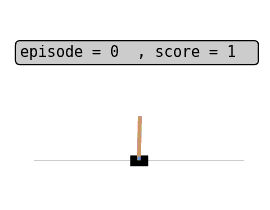

In [11]:
if SAVE_GIF:
    display(Image(open("out.gif", "rb").read()))

In [12]:
env.close()  # close Gym